In [1064]:
import numpy as np
import networkx as nx

import torch

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm import tqdm

from sklearn.model_selection import train_test_split

from decimal import Decimal, getcontext

import datamanip.plots
import importlib
import train_eval
import models
'''
importlib.reload(models.GAT)
importlib.reload(datamanip.plots)
importlib.reload(train_eval.train)

'''


'\nimportlib.reload(models.GAT)\nimportlib.reload(datamanip.plots)\nimportlib.reload(train_eval.train)\n\n'

In [1065]:

from filepath import *
from datamanip.plots import plot_rel_distribution, generate_matrix
from datamanip.feature_extraction import calculate_failure_rates
from datamanip.read_csvs import read_matrices, read_rel_values,merge_matrices_and_rel
from models.GAT import GAT#, GCN, SimpleMPNN
from train_eval.train import train
from train_eval.evaluate import evaluate



In [1066]:
# Number of epochs to train the model
NUM_EPOCHS = 100

# Dropout rate for the model to prevent overfitting
DROPOUT_RATE = 0.3

# Learning rate for the optimizer
LEARNING_RATE = 0.0005

# Threshold for classifying reliability
THRESHOLD = 0.97

# Number of features for each node in the graph
NODE_FEATURES = 8

# Number of epochs to wait for improvement before early stopping
PATIENCE = 15

# Flag to indicate whether to use only one timestamp
ONE_TIMESTAMP = False

NUM_BINS = 8



In [1067]:
## Class Imbalance Configuration

# Remove all values bellow 0.9
DELETE_FIRST_CLASS = False

# Use class weights for the loss function
CLASS_WEIGHTS = False

UNDER_SAMPLING = False

CLASS_WEIGHTS_MIN_THRESHOLD = False

OVER_SAMPLING = False

In [1068]:


# Read matrices and reliability values into one DataFrame
all_matrices_df = read_matrices(matrices_path)
all_rels_df = read_rel_values(reliabilities_path, config_all_path)
merged_df = merge_matrices_and_rel(all_matrices_df, all_rels_df)

# Explode the 'timestamp' and 'reliability' columns
merged_df_exploded = merged_df.explode(['timestamp', 'reliability']).reset_index(drop=True)


In [1069]:
# If the ONE_TIMESTAMP flag is set to True, filter the DataFrame to include only rows with a timestamp of 1000
if ONE_TIMESTAMP:
  merged_df_exploded = merged_df_exploded.loc[merged_df_exploded['timestamp'] == 1000]
  # Reset the index of the DataFrame after filtering
  merged_df_exploded = merged_df_exploded.reset_index(drop=True)

if DELETE_FIRST_CLASS:
    merged_df_exploded = merged_df_exploded.loc[merged_df_exploded['reliability'] >= 0.9]
    merged_df_exploded = merged_df_exploded.reset_index(drop=True)
# Display the shape of the DataFrame
merged_df_exploded.shape


(167736, 4)

In [1070]:
#Convert the matrices to edge indices

all_edge_indices : list[torch.Tensor] = []

merged_df_exploded['matrix'] = merged_df_exploded['matrix'].apply(np.array)

for _, row in merged_df_exploded.iterrows():
    matrix_np = row['matrix']

    # Get the indices where there are edges (i.e., non-zero entries)
    edge_indices = np.nonzero(matrix_np)

    # Stack the indices into a 2xN array where each column represents an edge
    edge_index = torch.tensor(np.vstack(edge_indices), dtype=torch.long)

    # Append the edge_index tensor to the list
    all_edge_indices.append(edge_index)

In [1071]:
max_reliability =  merged_df_exploded.loc[merged_df_exploded['reliability'] < 1, 'reliability'].max()

max_value_decimal = Decimal(str(max_reliability))  # Ensure precise representation
decimal_part = str(max_value_decimal).split('.')[1]  # Get the decimal part

count_nines = 0
for digit in decimal_part:
    if digit == '9':
        count_nines += 1
    else:
        break  # Stop counting when encountering the first non-9 digit


In [1072]:
getcontext().prec = count_nines + 2  # Set precision

bins = []
current_bin_start = Decimal('0')

for i in range(1, count_nines + 1):
    current_bin_end = Decimal('1') - Decimal(f'1e-{i}')
    bins.append((current_bin_start, current_bin_end))
    current_bin_start = current_bin_end

# Add the last bin for values very close to 1
# bins.append((current_bin_start, Decimal('1')))

if DELETE_FIRST_CLASS:
    bins.pop(0)




In [1073]:
def classify_into_bins(value, bins_nines):
    for idx, (bin_start, bin_end) in enumerate(bins_nines):
        if bin_start <= value < bin_end:
            return idx
    return len(bins)

In [1074]:
all_rels : list[int] = []

for _, row in merged_df_exploded.iterrows():
    reliability = row['reliability']
    bin_index = classify_into_bins(reliability, bins)
    all_rels.append(bin_index)


NUM_BINS = len(bins) + 1


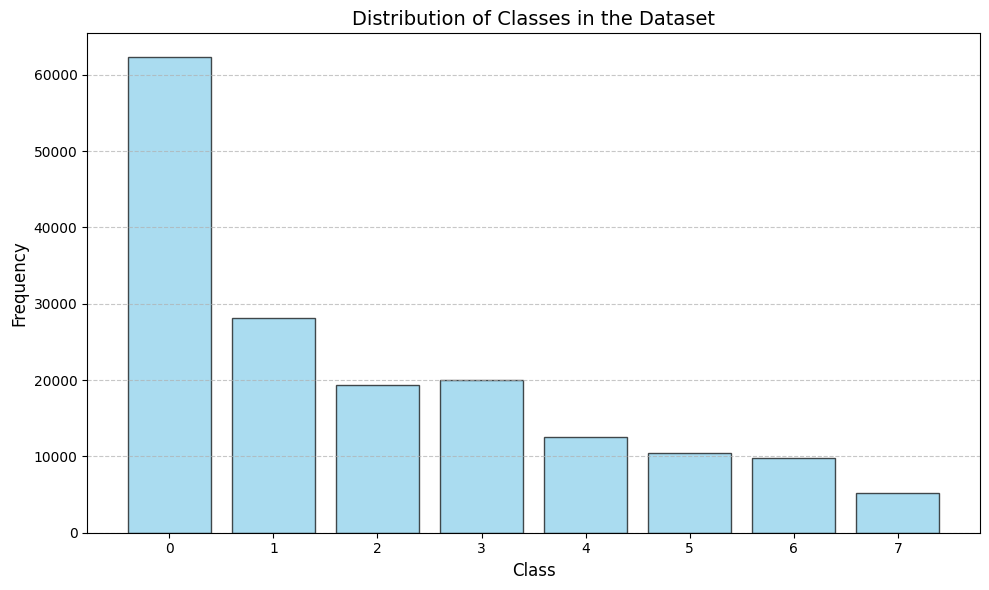

In [1075]:

plot_rel_distribution(all_rels)

In [1076]:
all_rels_tensor : torch.Tensor = torch.tensor(all_rels)

In [1077]:
from typing import Any, Union


In [1078]:
all_node_features: list[list[list[Union[float, int]]]] = []

for _, row in tqdm(merged_df_exploded.iterrows()):
    adj_matrix = row['matrix']
    timestamp = row['timestamp']

    G = nx.from_numpy_array(adj_matrix)

    # Centrality measures (handle NaN cases)
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = {node: val if not np.isnan(val) else 0.0 for node, val in nx.closeness_centrality(G).items()}
    betweenness_centrality = nx.betweenness_centrality(G)
    '''
    try:
        eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)
    except nx.PowerIterationFailedConvergence:
        eigenvector_centrality = {node: 0.0 for node in G.nodes}
    '''
    #pagerank = nx.pagerank(G, alpha=0.85)
    k_core = nx.core_number(G)
    degree = adj_matrix.sum(axis=1)

    failure_rates = calculate_failure_rates()

    mean_failure_rate_neighbors = {
        node: np.mean([failure_rates.get(n, 0.0) for n in G.neighbors(node)])
        if len(list(G.neighbors(node))) > 0 else 0.0
        for node in G.nodes
    }

    node_features_of_one_graph = []
    for node in G.nodes():
        node_features_of_one_node = [
            degree_centrality[node],
            closeness_centrality[node],
            degree[node],
            timestamp,
            failure_rates.get(node, 0.0),
            betweenness_centrality[node],
         #   eigenvector_centrality[node],
         #   pagerank[node],
            k_core[node],
            mean_failure_rate_neighbors[node]
        ]
        node_features_of_one_graph.append(node_features_of_one_node)

    all_node_features.append(node_features_of_one_graph)


node_features_tensor = torch.tensor(np.array(all_node_features), dtype=torch.float)

167736it [02:23, 1171.12it/s]


In [1079]:
'''
#Create node features for the GNN
num_features = NODE_FEATURES

all_node_features = []
for _, row in tqdm(merged_df_exploded.iterrows()):
    
  adj_matrix  = row['matrix'] # Matrix of the graph
  timestamp = row['timestamp'] # Timestamp when reliability was measured
  num_nodes = adj_matrix.shape[0] # Number of nodes in the graph
  node_features = np.zeros((num_nodes, num_features)) # Initialize node features
    
  #Get indegree and centrality using NetworksX graph
  G = nx.from_numpy_array(adj_matrix)

  # Calculate centrality measures
  degree_centrality = nx.degree_centrality(G)
  closeness_centrality = nx.closeness_centrality(G)
  degree = adj_matrix.sum(axis=1)
  # Calculate failure rates based on given topology parameters
  failure_rates = calculate_failure_rates()

  # Assign features to each node
  for node in G.nodes():
      node_features[node, 0] = degree_centrality[node]
      node_features[node, 1] = closeness_centrality[node]
      node_features[node, 2] = degree[node]
      node_features[node, 3] = timestamp
      node_features[node, 4] = failure_rates[node]

  all_node_features.append(node_features)
node_features_tensor = torch.tensor(np.array(all_node_features), dtype=torch.float)
'''

"\n#Create node features for the GNN\nnum_features = NODE_FEATURES\n\nall_node_features = []\nfor _, row in tqdm(merged_df_exploded.iterrows()):\n    \n  adj_matrix  = row['matrix'] # Matrix of the graph\n  timestamp = row['timestamp'] # Timestamp when reliability was measured\n  num_nodes = adj_matrix.shape[0] # Number of nodes in the graph\n  node_features = np.zeros((num_nodes, num_features)) # Initialize node features\n    \n  #Get indegree and centrality using NetworksX graph\n  G = nx.from_numpy_array(adj_matrix)\n\n  # Calculate centrality measures\n  degree_centrality = nx.degree_centrality(G)\n  closeness_centrality = nx.closeness_centrality(G)\n  degree = adj_matrix.sum(axis=1)\n  # Calculate failure rates based on given topology parameters\n  failure_rates = calculate_failure_rates()\n\n  # Assign features to each node\n  for node in G.nodes():\n      node_features[node, 0] = degree_centrality[node]\n      node_features[node, 1] = closeness_centrality[node]\n      node_featu

In [1080]:
#Create list of Data objects, each containing the node features, edge indices, and target values
data_list = []

for i, row in merged_df_exploded.iterrows():
  node_features = node_features_tensor[i]
  edge_index = all_edge_indices[i]
  y = all_rels[i]
  data = Data(x=node_features, edge_index=edge_index, y=y)
  data_list.append(data)

In [1081]:
!pip install imblearn


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [1082]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
y = [data.y for data in data_list]  # Convert tensor labels to integers
indices = list(range(len(data_list)))


if UNDER_SAMPLING:
# ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
    ros = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
    indices_resampled, y_resampled = ros.fit_resample([[i] for i in indices], y)
    data_list = [data_list[i[0]] for i in indices_resampled]

    plot_rel_distribution([data.y for data in data_list])

elif OVER_SAMPLING:
    count = np.bincount(y)
    print(count)
    ros = RandomOverSampler(sampling_strategy={0: int(count[0]*1),1: int(count[1]*1), 2: int(count[2]*1.1),3: int(count[3]*1.5),4: int(count[4]*1.7),5: int(count[5]*1.9),6: int(count[6]*1.9),7: int(count[7]*2.5)}, random_state=42) 
    indices_resampled, y_resampled = ros.fit_resample([[i] for i in indices], y)
    data_list = [data_list[i[0]] for i in indices_resampled]

    plot_rel_distribution([data.y for data in data_list])



In [1083]:
# Split into training and testing data
train_data_list, test_data_list  = train_test_split(data_list, test_size=0.2, random_state=42)

# Further split training data into training and validation
train_data_list, val_data_list = train_test_split(train_data_list, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2 validation split

# Create DataLoaders
train_loader = DataLoader(train_data_list, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data_list, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_data_list)}")
print(f"Validation samples: {len(val_data_list)}")
print(f"Test samples: {len(test_data_list)}")


Training samples: 100641
Validation samples: 33547
Test samples: 33548


In [1112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT(input_dim=NODE_FEATURES, hidden_dim=128, output_dim=NUM_BINS, dropout_rate=DROPOUT_RATE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE  ) # weight_decay=0.0001


In [1113]:
total_samples = all_rels_tensor.size(0)
class_counts = torch.bincount(all_rels_tensor)

if CLASS_WEIGHTS:
    class_weights = total_samples / (NUM_BINS * class_counts)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
elif CLASS_WEIGHTS_MIN_THRESHOLD:
    class_counts = class_counts + 1e-6
    class_weights = total_samples / (NUM_BINS * class_counts)
    class_weights = class_weights / class_weights.sum()
    print("Before: ", class_weights)
    class_weights = torch.clamp(class_weights, min=0.1, max=0.16)
    print("After: ", class_weights)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
else:
    criterion = torch.nn.CrossEntropyLoss()

In [1114]:
train_config = {
    "num_epochs": NUM_EPOCHS,
    "patience": PATIENCE,
    "device": device,
    "criterion": criterion,
    "optimizer": optimizer,
}

In [1115]:
training_losses, validation_losses = train(model, train_loader, val_loader, train_config, model_checkpoints_path + "best_model_GAT_MCC.pth")

Epoch 1/100, Train Loss: 1.1322
Epoch 1/100, Validation Loss: 1.1624
Best model updated based on validation loss.
Epoch 2/100, Train Loss: 1.0208
Epoch 2/100, Validation Loss: 1.0562
Best model updated based on validation loss.
Epoch 3/100, Train Loss: 0.9625
Epoch 3/100, Validation Loss: 1.0177
Best model updated based on validation loss.
Epoch 4/100, Train Loss: 0.9124
Epoch 4/100, Validation Loss: 0.9749
Best model updated based on validation loss.
Epoch 5/100, Train Loss: 0.8734
Epoch 5/100, Validation Loss: 1.1673
No improvement in validation loss for 1 epoch(s).
Epoch 6/100, Train Loss: 0.8516
Epoch 6/100, Validation Loss: 0.9496
Best model updated based on validation loss.
Epoch 7/100, Train Loss: 0.8227
Epoch 7/100, Validation Loss: 1.2627
No improvement in validation loss for 1 epoch(s).
Epoch 8/100, Train Loss: 0.8122
Epoch 8/100, Validation Loss: 1.1510
No improvement in validation loss for 2 epoch(s).
Epoch 9/100, Train Loss: 0.8127
Epoch 9/100, Validation Loss: 1.9459
No i

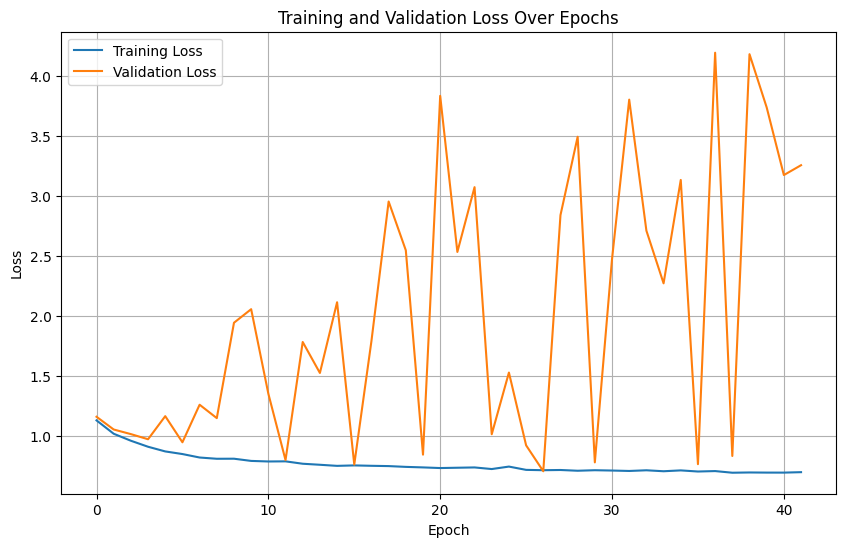

In [1116]:
# Plot the training and validation losses
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



In [1117]:
# Load the best model after training
model.load_state_dict(torch.load(model_checkpoints_path + "best_model_GAT_MCC.pth", weights_only=True))

<All keys matched successfully>

In [1118]:
true_values, predicted_values, accuracy = evaluate(device, model, test_loader, model_checkpoints_path + "best_model_GAT_MCC.pth")

GAT(
  (conv1): GATConv(8, 128, heads=1)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(128, 64, heads=1)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=8, bias=True)
)
[np.int64(4), np.int64(3), np.int64(2), np.int64(3), np.int64(4), np.int64(0), np.int64(3), np.int64(0), np.int64(0), np.int64(1)]
[np.int64(3), np.int64(3), np.int64(1), np.int64(3), np.int64(3), np.int64(0), np.int64(2), np.int64(0), np.int64(0), np.int64(2)]
Accuracy: 0.6940


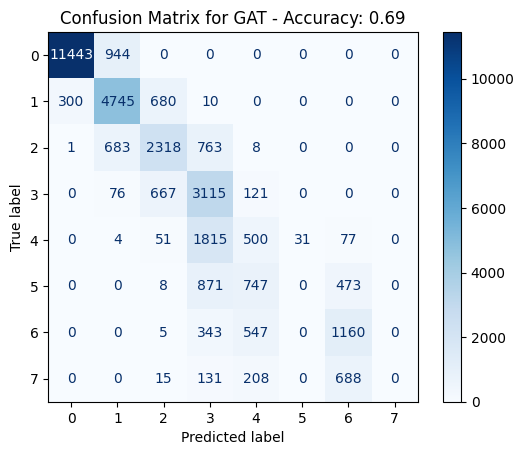

In [1119]:
generate_matrix(true_values, predicted_values, accuracy, "GAT")

# Experiments
1. Original 0.6758%
2. Class Weights 0.6460% but class 7 was predicted
3. Class Weights + REMOVE_FIRST_CLASS 0.5589%
4. Oversampling Majority  0.5911%